In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Datenvorbereitung

In [12]:
#Datenverzeichnis: train, validation, test daten
data_dir = "PlantVillage-Dataset/color/"
image_size = (224, 224)
batch_size = 32
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size
)
# Anzahl der Daten bestimmen
dataset_size = len(full_ds)
train_size = int(0.7 * dataset_size)  # 70% für Training
val_size = int(0.2 * dataset_size)    # 20% für Validation
test_size = dataset_size - train_size - val_size  # 10% für Test
print(dataset_size)
print(train_size)
print(val_size)
print(test_size)

# Datasets aufteilen
train_ds = full_ds.take(train_size)  # Nimmt die ersten `train_size` Beispiele
remaining = full_ds.skip(train_size) # Überspringt die Trainingsdaten
val_ds = remaining.take(val_size)    # Nimmt die nächsten `val_size` Beispiele
test_ds = remaining.skip(val_size)   # Rest für Test-Daten

# Anzahl der Klassen
#num_classes = len(full_ds.class_names)
#print(f"Anzahl der Klassen: {num_classes}")
# Anzahl der Beispiele in jedem Satz
print(f"Trainingsdatensatz: {len(train_ds)} Beispiele")
print(f"Validierungsdatensatz: {len(val_ds)} Beispiele")
print(f"Testsdatensatz: {len(val_ds)} Beispiele")

# Anzahl der Klassen
class_names = full_ds.class_names
num_classes = len(class_names)
print(f"Anzahl der Klassen: {num_classes}")
print(f"Klassen: {class_names}")

Found 54306 files belonging to 38 classes.
1698
1188
339
171
Trainingsdatensatz: 1188 Beispiele
Validierungsdatensatz: 339 Beispiele
Testsdatensatz: 339 Beispiele
Anzahl der Klassen: 38
Klassen: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'T

## Anzeige der Planzen

tf.Tensor(
[27 23 13 16 35  6 37 10 25 34  1 13 33 25  4  8 15 35 35 19 10  1 29  4
 35  8 15 28  3 26 30 37], shape=(32,), dtype=int32)
tf.Tensor(27, shape=(), dtype=int32)
Strawberry___healthy
tf.Tensor(23, shape=(), dtype=int32)
Raspberry___healthy
tf.Tensor(13, shape=(), dtype=int32)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
tf.Tensor(16, shape=(), dtype=int32)
Peach___Bacterial_spot
tf.Tensor(35, shape=(), dtype=int32)
Tomato___Tomato_Yellow_Leaf_Curl_Virus
tf.Tensor(6, shape=(), dtype=int32)
Cherry_(including_sour)___healthy


2025-02-05 17:05:40.479464: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


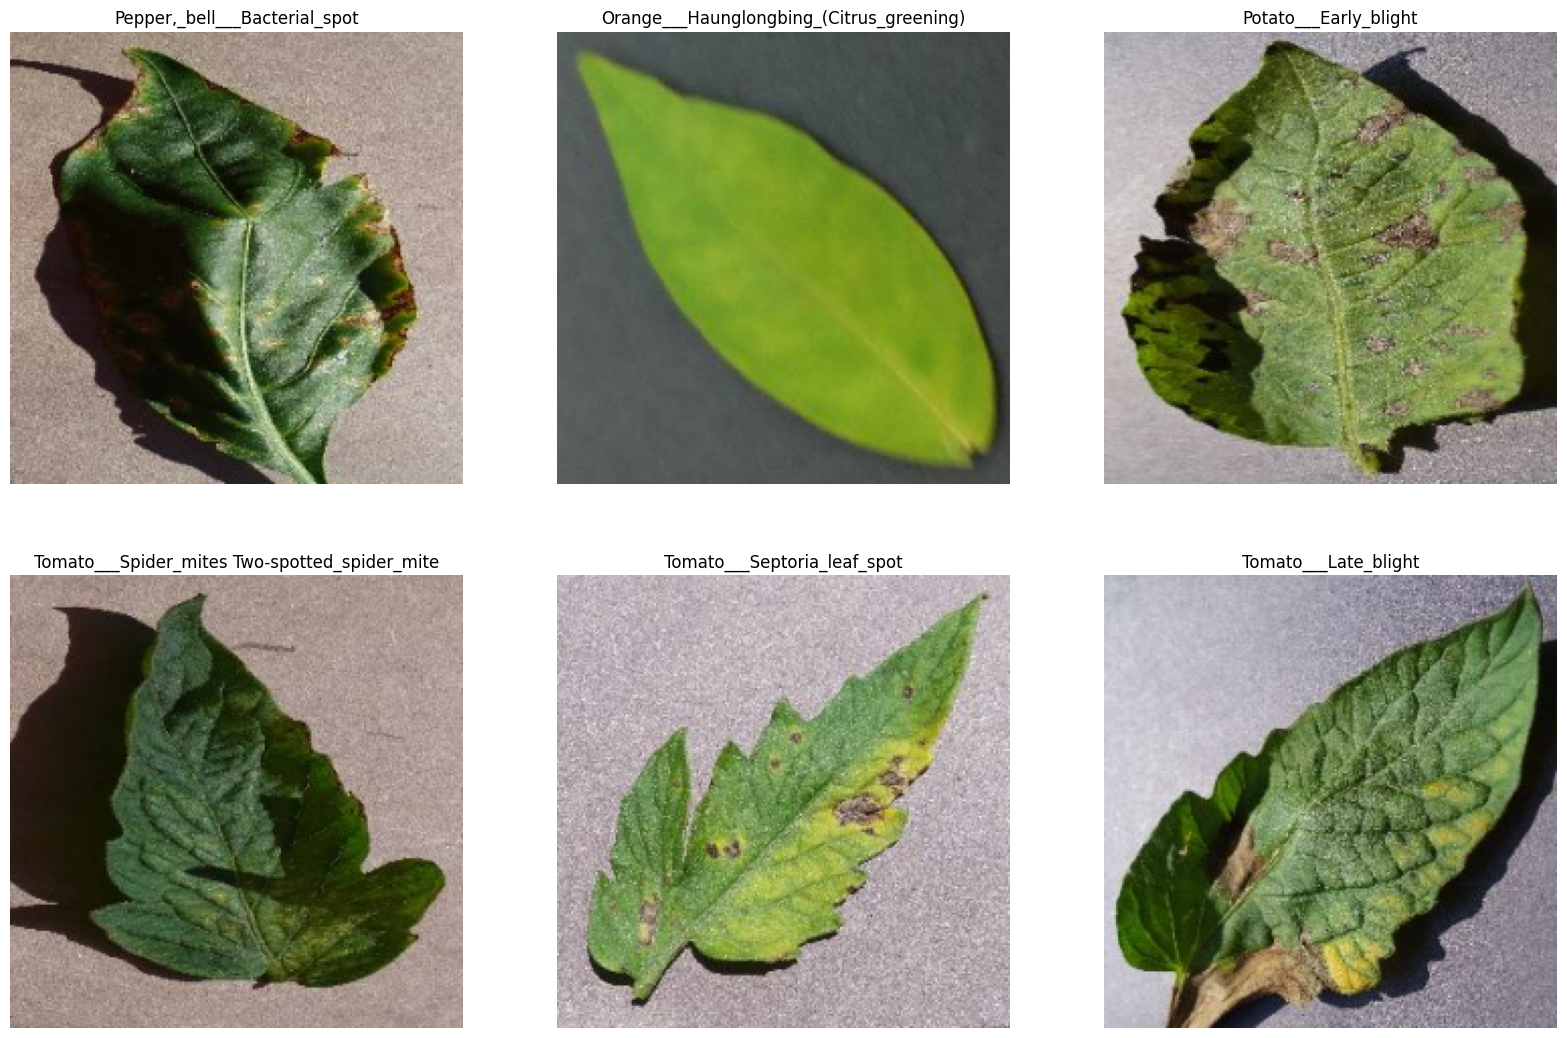

In [13]:
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(6):
        print(labels[i])
        print(class_names[labels[i]])
#Displaying a few sample images
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Normalisierung

In [14]:
# Normalisierung der Pixelwerte [0, 255] → [0, 1]
AUTOTUNE = tf.data.AUTOTUNE
# Normalisierungsschicht
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Normalisierung anwenden
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetching für Effizienz
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


##  Laden des vortrainierten ResNet50v2-Modells

In [15]:

# Vortrainiertes Modell laden
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,  # Ohne Klassifikationskopf
    input_shape=(224, 224, 3)  # Größe der Eingabebilder
)
print(len(base_model.layers))

# Freezing der vortrainierten Schichten
base_model.trainable = False
#plot_model(base_model)

190


## Hinzufügen eines neuen Klassifikationskopfes

In [16]:
# Neues Modell erstellen
model = models.Sequential([
    base_model,  # Vortrainiertes Modell als Basis
    layers.GlobalAveragePooling2D(),  # Reduktion der Merkmalskarten
    layers.Dense(512, activation='relu'),  # Vollständig verbundene Schicht
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Dropout zur Vermeidung von Overfitting
    layers.Dense(256, activation='relu'),  # Vollständig verbundene Schicht
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Dropout zur Vermeidung von Overfitting
    layers.Dense(128, activation='tanh'),  # Vollständig verbundene Schicht
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Dropout zur Vermeidung von Overfitting
    layers.Dense(num_classes, activation='softmax')  # Klassifikationsausgabe
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,786,598 (94.55 MB)

 Trainable params: 1,220,006 (4.65 MB)

 Non-trainable params: 23,566,592 (89.90 MB)

##  Kompilieren und Trainieren des Modells

In [17]:
# Zielwerte in One-Hot-Codierung umwandeln -> benutzt  categorical_crossentropy, else sparse_categorical_crossentropy
#train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
#val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
#Umrechnung der Labels in Vektordarstellung (Hot-Vektor-Encoding)
#total_classes = 10
#train_vec_labels = keras.utils.to_categorical(train_ds, total_classes)
#test_vec_labels = keras.utils.to_categorical(val_ds, total_classes)
#print(train_vec_labels.shape)

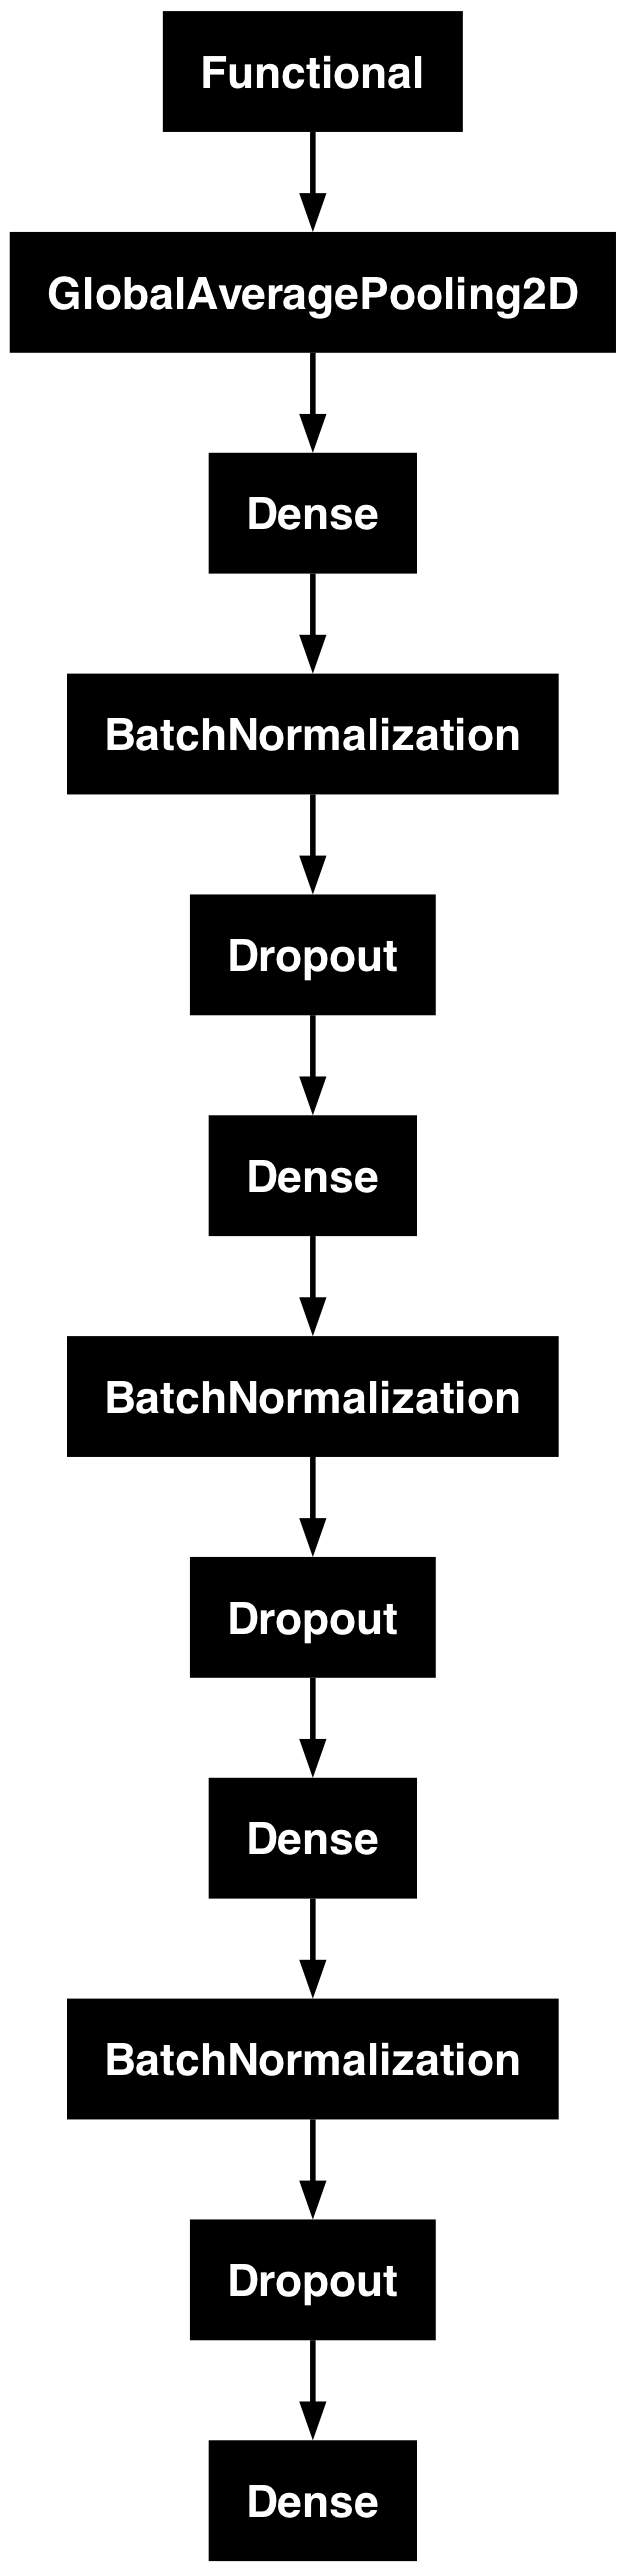

In [18]:
plot_model(model)

In [19]:
# Callbacks definieren
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Überwacht den Validierungsverlust
    patience=5,  # Stoppt nach 5 Epochen ohne Verbesserung
    restore_best_weights=True  # Beste Gewichte wiederherstellen
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Überwacht den Validierungsverlust
    factor=0.2,  # Reduziert die Lernrate um 20%
    patience=3,  # Wenn sich der Verlust für 3 Epochen nicht verbessert, LR reduzieren
    min_lr=1e-6,  # Minimale Lernrate
    verbose=1 # Ausgabe, wenn die Lernrate geändert wird
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=128,
    verbose=True, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 674s 566ms/step - accuracy: 0.7481 - loss: 0.9105 - val_accuracy: 0.9229 - val_loss: 0.2333 - learning_rate: 0.0010
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 676s 569ms/step - accuracy: 0.9058 - loss: 0.2971 - val_accuracy: 0.9303 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 675s 568ms/step - accuracy: 0.9207 - loss: 0.2414 - val_accuracy: 0.9452 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 688s 579ms/step - accuracy: 0.9359 - loss: 0.2013 - val_accuracy: 0.9494 - val_loss: 0.1529 - learning_rate: 0.0010
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 690s 581ms/step - accuracy: 0.9413 - loss: 0.1770 - val_accuracy: 0.9534 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 694s 584ms/step - accuracy: 0.9480 - loss: 0.1596 - val_accuracy: 0.9551 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 7/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 745s 627ms

## Finetuning der Basis

In [21]:
# Vortrainierte Schichten freigeben
base_model.trainable = True
# Optional: nur die letzten Layer trainieren
for layer in base_model.layers[:150]:
    layer.trainable = False

# Finetuning-Lernrate reduzieren
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Geringere Lernrate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Weiteres Training
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=128,
    verbose=True, 
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 999s 838ms/step - accuracy: 0.9120 - loss: 0.2983 - val_accuracy: 0.9695 - val_loss: 0.0920 - learning_rate: 1.0000e-04
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1001s 843ms/step - accuracy: 0.9732 - loss: 0.0876 - val_accuracy: 0.9757 - val_loss: 0.0755 - learning_rate: 1.0000e-04
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1126s 948ms/step - accuracy: 0.9813 - loss: 0.0572 - val_accuracy: 0.9854 - val_loss: 0.0494 - learning_rate: 1.0000e-04
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1003s 845ms/step - accuracy: 0.9854 - loss: 0.0456 - val_accuracy: 0.9820 - val_loss: 0.0599 - learning_rate: 1.0000e-04
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1010s 850ms/step - accuracy: 0.9869 - loss: 0.0422 - val_accuracy: 0.9853 - val_loss: 0.0450 - learning_rate: 1.0000e-04
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 996s 839ms/step - accuracy: 0.9887 - loss: 0.0335 - val_accuracy: 0.9853 - val_loss: 0.0472 - learning_rate: 1.0000e-04
Epoch 7/10
1188/1188 ━━━

## Bewertung und Visualisierung

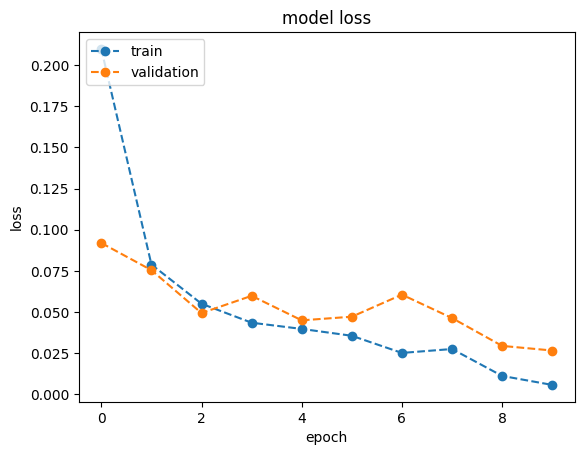

In [22]:
#Erstellen eines Plots der history-Daten in Matplotlib Plot des Fehlerverlaufs (Loss) während des Trainings
plt.plot(history_finetune.history['loss'],'o--')
plt.plot(history_finetune.history['val_loss'],'o--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

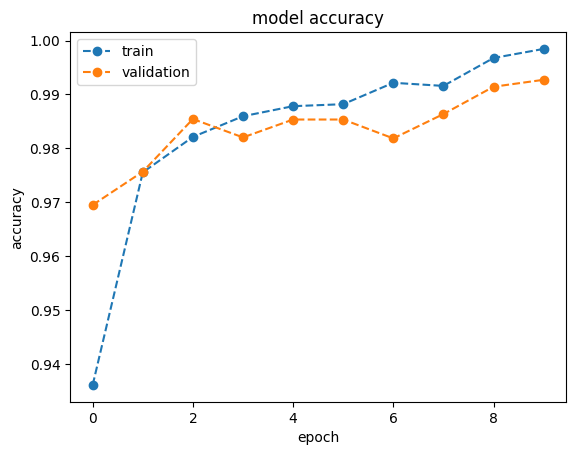

In [23]:
plt.plot(history_finetune.history['accuracy'],'o--')
plt.plot(history_finetune.history['val_accuracy'],'o--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Bewertung und Visualisierung auf Testdaten


In [24]:
loss_test, accuracy_test = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy_test:.2f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.9926 - loss: 0.0251 
Test Accuracy: 0.99


In [25]:
# Ein Batch von Testbildern
countTotal = 0
countTrue = 0
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    countPredictions = len(predictions)
    countTotal += countPredictions
    #print("total" + countTotal)

    #plt.figure(figsize=(15, 10))
    for i in range(countPredictions):  # Zeigt die ersten 9 Bilder
        #plt.subplot(3, 3, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(f"True: {labels[i]}, Pred: {predicted_labels[i]}")
        #plt.axis("off")
        #print(f"True: {labels[i]}, Pred: {predicted_labels[i]}")
        if class_names[labels[i]] == class_names[predicted_labels[i]]:
            countTrue = countTrue + 1
    #plt.show()
print(f"Anzahl der Testdaten: {countTotal}")
print(f"Anzahl der True Vorhersagen: {countTrue}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


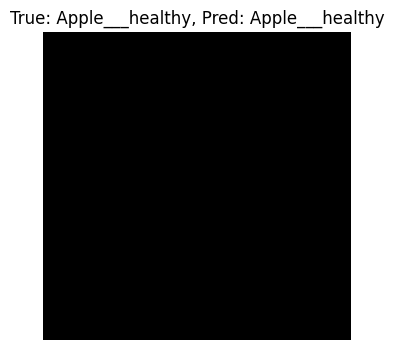

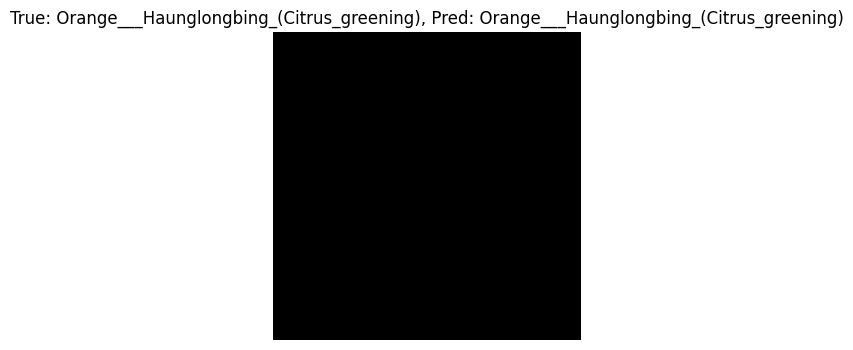

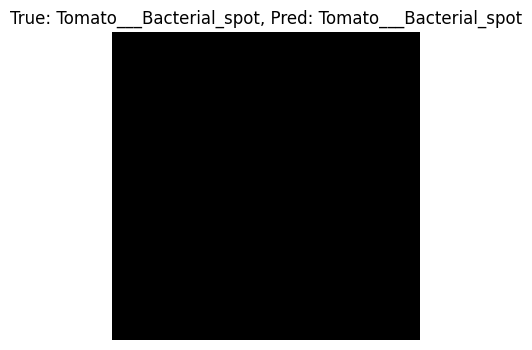

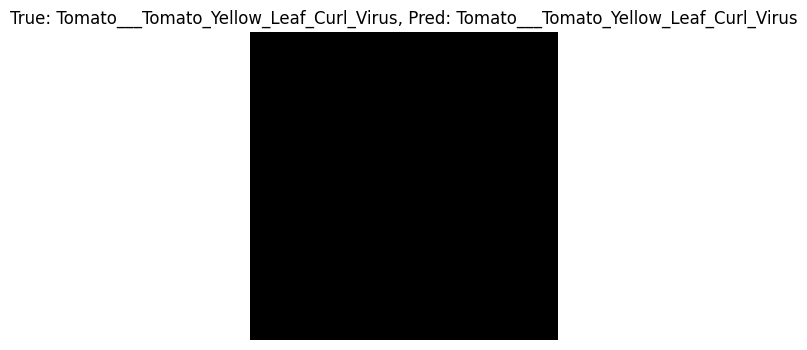

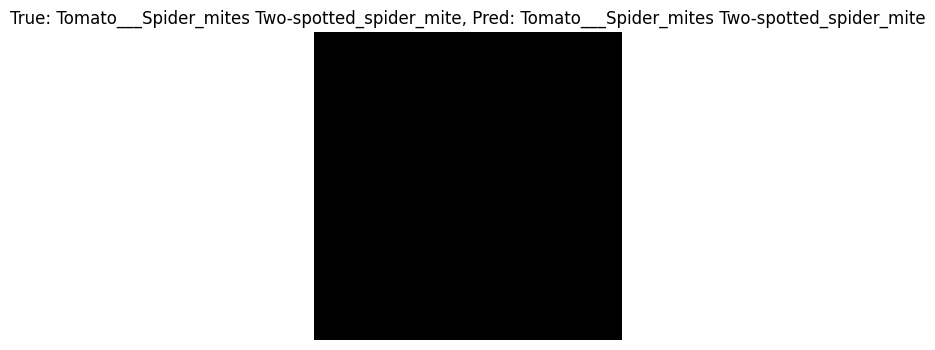

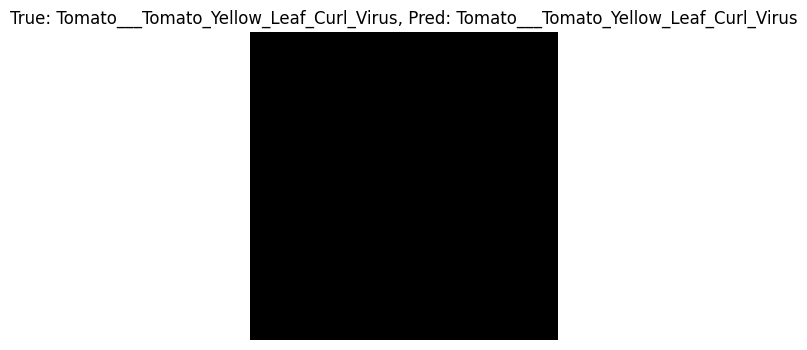

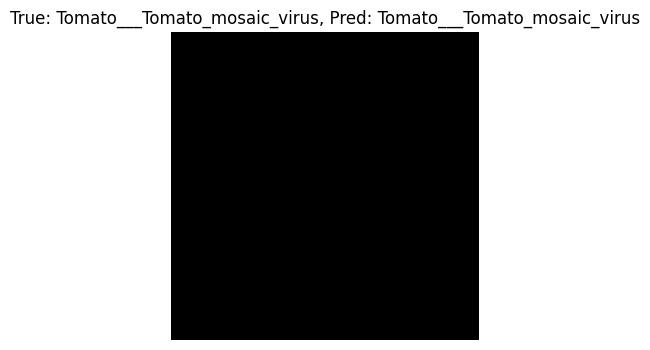

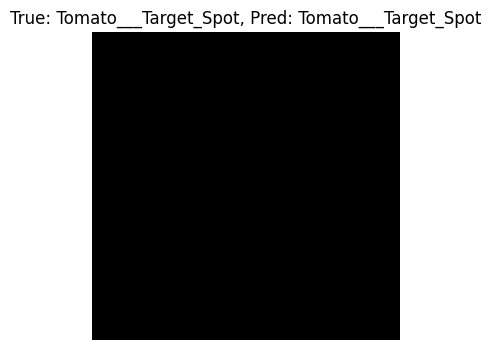

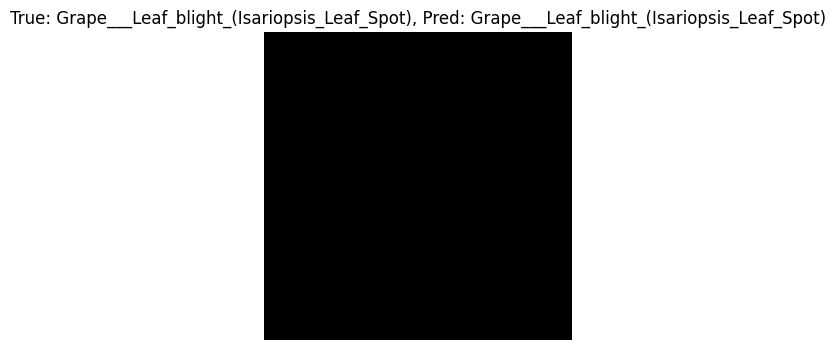

In [27]:
# Vorhersage für das Bild
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

   
    for i in range(9):  # Zeigt die ersten 9 Bilder
        plt.figure(figsize=(4, 4))
        #plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-02-05 22:40:53.026130: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


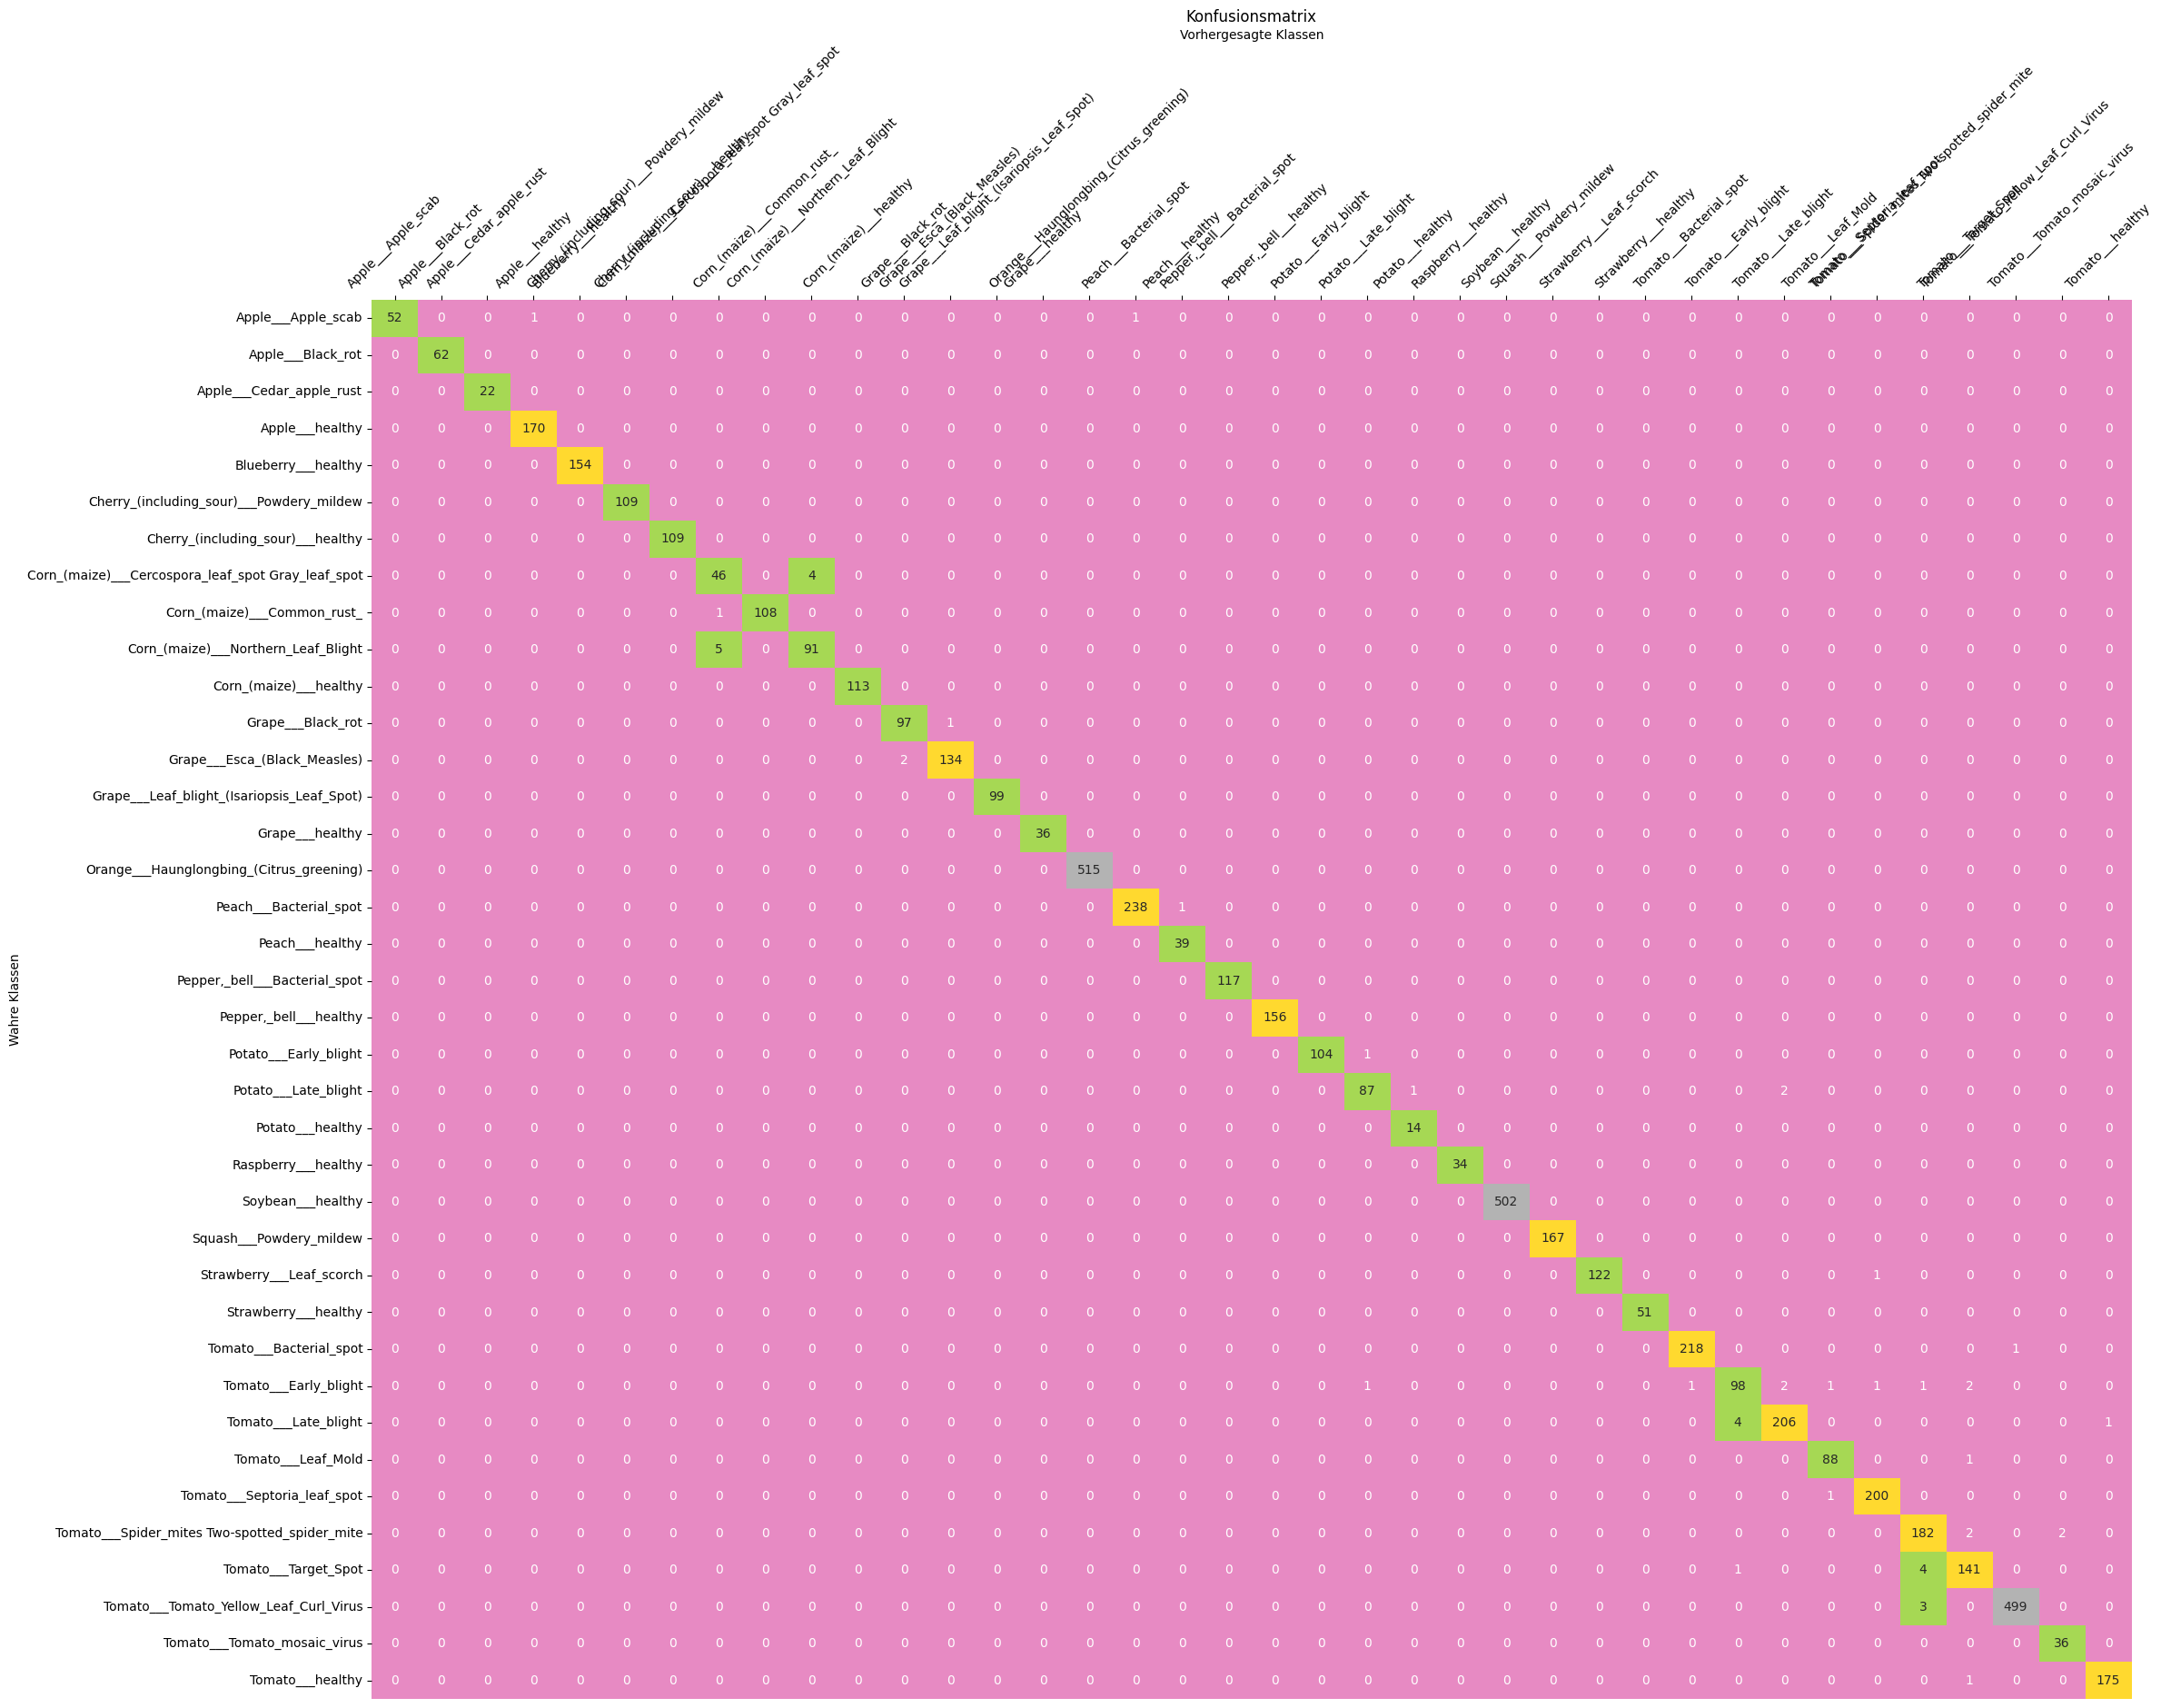

In [28]:
# y_true: echte Labels (z. B. aus einem DataLoader)
# y_pred: Vorhergesagte Labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    countPredictions = len(predictions)
    countTotal += countPredictions

    for i in range(countPredictions):
        y_true.append(class_names[labels[i]])
        y_pred.append(class_names[predicted_labels[i]])

# Konfusionsmatrix erstellen
conf_matrix = confusion_matrix(y_true, y_pred)
# Visualisieren der Konfusionsmatrix
plt.figure(figsize=(25, 20))
ax=sns.heatmap(conf_matrix, center=True, cbar=False, annot=True, fmt='d', cmap='Set2', xticklabels=class_names, yticklabels=class_names) #Blues
#ax=sns.heatmap(conf_matrix, fmt='g', center=True, cbar=False, annot=True, cmap='Set2',
#            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.tick_top()  # Labels der x-Achse nach oben verschieben
ax.xaxis.set_label_position('top')  # Position der x-Achsenbeschriftung auf oben setzen
ax.tick_params(axis='x', rotation=45)  # Drehen der xticklabels für bessere Lesbarkeit
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Wahre Klassen')
plt.title('Konfusionsmatrix')
plt.show()


In [29]:
# Klassifikationsbericht anzeigen
print(classification_report(y_true, y_pred, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.96      0.98        54
                                 Apple___Black_rot       1.00      1.00      1.00        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        22
                                   Apple___healthy       0.99      1.00      1.00       170
                               Blueberry___healthy       1.00      1.00      1.00       154
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       109
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       109
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.92      0.90        50
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       109
               Corn_(maize)___Northern_Leaf_Blight       0.96      0.95      0.